In [1]:
import datetime
def date_s():
  return datetime.datetime.now().isoformat().replace('.','-').replace(':','-')[:-7] +'Z' 

print('Start at', date_s())

Start at 2020-12-07T18-33-21Z


In [2]:
import sys
!{sys.executable} -m pip install -r requirements.txt

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
import boto3
import datetime
import json
import math 
import matplotlib.pyplot as plt   
from matplotlib import pyplot
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.deserializers import StringDeserializer
from sagemaker.estimator import Estimator
from sagemaker.predictor import Predictor
from sagemaker.serializers import LibSVMSerializer
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
import seaborn  
from sklearn.datasets import dump_svmlight_file   
from sklearn.metrics import * 
from sklearn.model_selection import train_test_split
import sys
import time
from xgboost import XGBClassifier

In [4]:
%%time

session = sagemaker.Session() 
region = session.boto_region_name 

bucket = 'sagemaker-jfox'
prefix = 'sagemaker/xgboost'
role = sagemaker.get_execution_role()

print(f'Bucket {bucket} in region {region}')

Bucket sagemaker-jfox in region eu-west-1
CPU times: user 211 ms, sys: 7.19 ms, total: 218 ms
Wall time: 2.26 s


In [5]:
%%time
filename='from_databrew.parquet.snappy' 
s3 = boto3.resource('s3', region_name=region)

#s3.Bucket(bucket).download_file(
# 'normalize-3-snappy-parquet/normalize-3_02Dec2020_1606903905135/normalize-3_02Dec2020_1606903905135_part00000.parquet.snappy',
#    filename)
table = pq.read_table(filename)
df = table.to_pandas()    
    
print('Length', len(df))

Length 6362620
CPU times: user 1.09 s, sys: 599 ms, total: 1.69 s
Wall time: 1.62 s


## Optionally sample 
... a fraction of the dataset for fast cycles in development.

In [6]:
fraction_to_retain = 1.0
df = df.sample(frac=fraction_to_retain, replace=True, random_state=1)
if fraction_to_retain < 1.0:
    print('Length after downsampling', len(df))
df

,isFraud,hour,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amount_nml,oldBalanceOrigin_nml,newBalanceOrigin_nml,oldBalanceDestination_nml,newBalanceDestination_nml
4322341,0,20.0,0,0,0,1,0,-0.229409,-0.287947,-0.292442,-0.323814,-0.333411
4686059,0,19.0,0,0,0,1,0,-0.288739,-0.288716,-0.292442,-0.323814,-0.333411
3937352,0,22.0,0,1,0,0,0,-0.085726,-0.288716,-0.292442,2.193641,2.030517
491263,0,19.0,0,1,0,0,0,-0.064778,-0.288716,-0.292442,0.229449,0.216756
5030793,0,18.0,0,1,0,0,0,-0.037904,-0.199619,-0.258119,1.646407,1.532095
...,...,...,...,...,...,...,...,...,...,...,...,...
1858543,0,20.0,1,0,0,0,0,0.021337,1.802330,1.838917,-0.167669,-0.241412
2581057,0,15.0,0,0,0,1,0,-0.255680,-0.288547,-0.292442,-0.323814,-0.333411
4724952,0,20.0,0,0,0,1,0,-0.292877,-0.256813,-0.261957,-0.323814,-0.333411
923095,0,19.0,0,1,0,0,0,0.059901,-0.288716,-0.292442,-0.222012,-0.180429


In [7]:
target_col='isFraud'

# Data visualization and analysis

## Count positive and negative cases

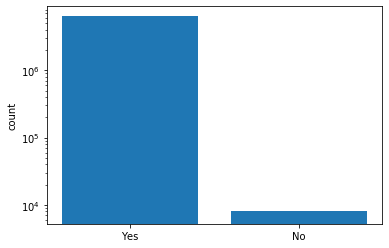

In [8]:
def count_positive_and_negative(df):
    num_positive = len(df.loc[  df[target_col] == 1 ])
    num_negative = len(df) - num_positive
    return num_positive, num_negative

def plot_positive_negative_counts(df, target_col):
    val_counts=df['isFraud'].value_counts()
    fig, ax = plt.subplots()
    ax.set(yscale='log')
    plt.bar(['Yes', 'No'], val_counts)
    plt.ylabel('count')
    plt.show()
    
plot_positive_negative_counts(df,'isFraud')

# Heatmap  showing correlation between features  

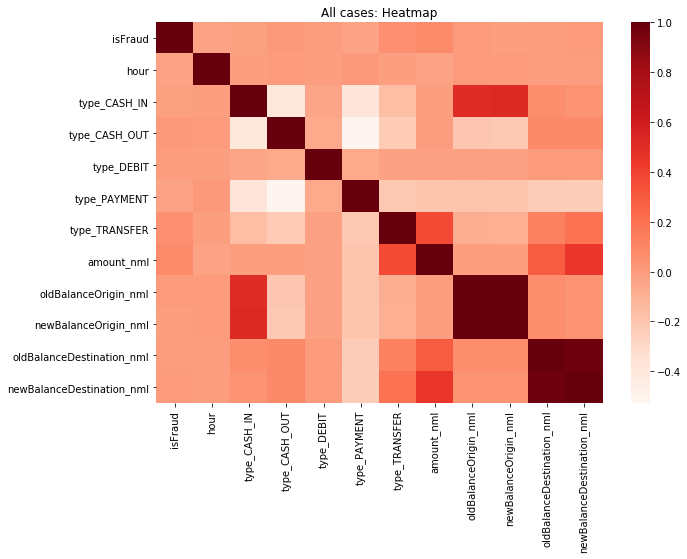

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
 
ax.set_title(f'All cases: Heatmap')
seaborn.heatmap(df.corr(), cmap='Reds' )
 
plt.show()

# Heatmap  showing correlation between features in the fraud case and the non-fraud case.

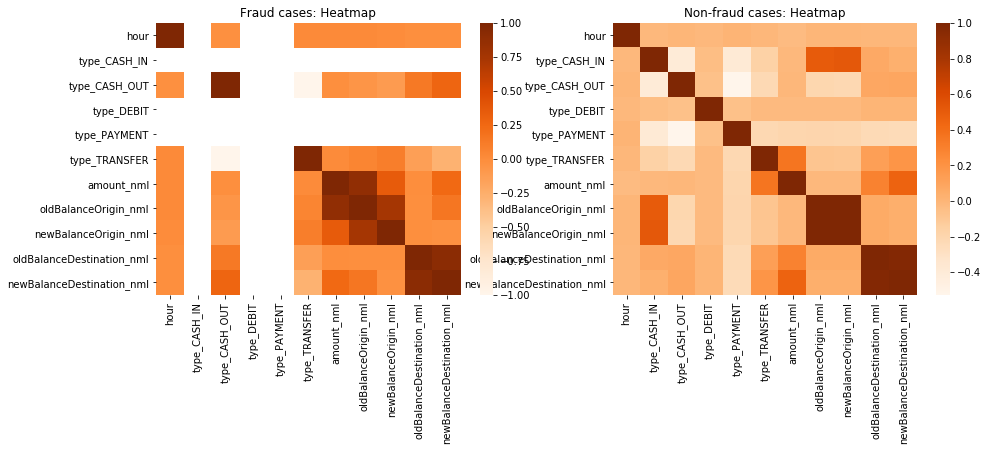

In [10]:
fig, axes = plt.subplots( 1,2, figsize=(15,5))

def heatmap(fraud_cases):
    lbl = 'Fraud' if  fraud_cases else 'Non-fraud'
    axes[1 - int(fraud_cases)].set_title(f'{lbl} cases: Heatmap')
    seaborn.heatmap(df.query(f'isFraud == {fraud_cases}').drop(['isFraud'], 1).corr(), cmap='Oranges', ax=axes[1-fraud_cases])

heatmap(True)
heatmap(False)

plt.show()

# Plot fraud percentage across the hours in the day.
(We actually don't know that step 0 is at midnight, so we don't know that, for example,
hour 2 is 2 am. But a clear cyclical pattern appears.

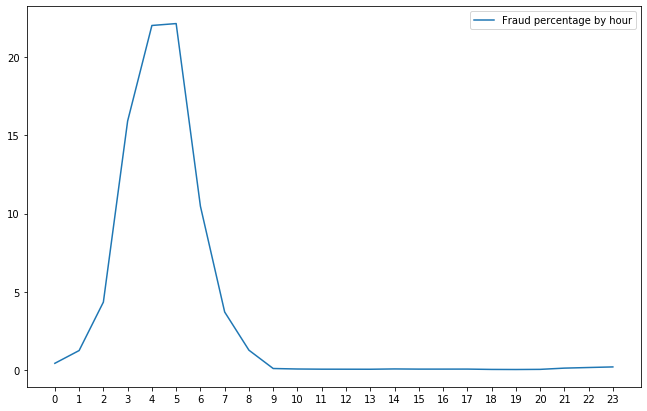

In [11]:
HOURS_IN_DAY  =24

frauds_by_hour = []
non_frauds_by_hour = []
hourwise_items = []
for hour in range(HOURS_IN_DAY):
    non_fraud_in_hour = df[(df['hour'] == hour) & (df['isFraud'] == 0)]
    non_fraud_sum_in_hour = len(non_fraud_in_hour)
    fraud_in_hour = df[(df['hour'] == hour) & (df['isFraud'] == 1)]
    fraud_sum_in_hour = len(fraud_in_hour)
    non_frauds_by_hour.append(non_fraud_sum_in_hour)
    frauds_by_hour.append(fraud_sum_in_hour)
    hourwise_items.append(non_fraud_sum_in_hour+fraud_sum_in_hour)

fig, axis = plt.subplots(figsize=(11, 7))
 
fr_non_fraud = axis.plot(np.multiply(np.divide(frauds_by_hour,hourwise_items), 100), label='Fraud percentage by hour')
plt.xticks(range(24))
legend = axis.legend(loc='upper right' )



# Data preparation: Add non-peak hours field. This could have been done in Databrew but they have limited logical functions on offer and so we do it here.

In [12]:
peak_hours_mask = (df['hour'] >=2) & (df['hour'] <= 6 )
df[peak_hours_mask]['peakHours'] = 1
nonpeak_hours_mask = (df['hour'] <2) | (df['hour'] > 6 )
df[nonpeak_hours_mask]['peakHours'] = 0

conditions = [
    (df['hour'] < 2) | (df['hour'] > 6),
    (df['hour'] >=2) & (df['hour'] <= 6) ]
values = [0,1]
df['peakHours'] = np.select(conditions, values)

del df['hour']

# Define metrics calculation function. Metrics are to be printed in order of importance for our unbalanced dataset.

In [13]:
def calculate_metrics(y_test, y_pred):
    predictions = [round(value) for value in y_pred]
    # Not auc, roc_auc_score
    functions = [f1_score, balanced_accuracy_score,  accuracy_score, precision_score, recall_score, zero_one_loss]
    for f in functions:
        name = f.__name__.replace('_score','').replace('_', ' ')
        print(f'{name}: {f(y_test, predictions):.4f}' )

# Start Sagemaker (non-local) train/deploy/predict sequence 

## Prepare training, validation, and test sets

In [14]:
%%time
print('Preparing 3 sets at', date_s())
len_ = len(df)
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.5 * len_), int(0.7 * len_)])

lengths = [] 

for d in [(train_data, 'train.libsvm'), ( validation_data, 'validation.libsvm'), (test_data, 'test.libsvm')]:
   dataset = d[0]
   file_ = d[1]
   lengths.append((d[1].split('.')[0],len(dataset)))
   dump_svmlight_file(X=dataset.drop([target_col], axis=1), y=dataset[target_col], f=d[1])
   print('Wrote', d[1])
print('Length of datasets:', lengths )

Preparing 3 sets at 2020-12-07T18-33-40Z
Wrote train.libsvm
Wrote validation.libsvm
Wrote test.libsvm
Length of datasets: [('train', 3181310), ('validation', 1272524), ('test', 1908786)]
CPU times: user 4min 12s, sys: 1.82 s, total: 4min 14s
Wall time: 4min 14s


In [15]:
s3 = boto3.resource('s3', region_name=region)#TODO Remove

for filename in ['train.libsvm', 'validation.libsvm']:
   s3.Bucket(bucket).Object(prefix + '/'+filename.split('.')[0]+'/'+filename).upload_file(filename)

In [16]:
def s3_path(subset):
  return sagemaker.TrainingInput(s3_data='s3://{}/{}/{}'.format(bucket, prefix,subset), content_type='libsvm')

s3_input_train = s3_path('train')
s3_input_validation =s3_path('validation')

## Train, including hyperparameter tuning

In [17]:
container = get_image_uri(region, 'xgboost','1.0-1')
use_spot = True
base_job_name = 'fraud-detection-job'
instance_type = 'ml.c5.xlarge'
output_path = f's3://{bucket}/{prefix}/output'
HOUR = 60 * 60 

if use_spot:
   xgb = Estimator(container, 
                role,  
                base_job_name=base_job_name,
                instance_count=2, 
                instance_type=instance_type,
                output_path=output_path, 
                sagemaker_session=session,
                train_use_spot_instances=True,
                train_max_wait=HOUR,
                train_max_run=HOUR,    
                checkpoint_s3_uri=f's3://{bucket}/{prefix}/checkpoint',
   )
else:
   xgb = Estimator(container, 
                role,  
                base_job_name=base_job_name,
                instance_count=2, 
                instance_type=instance_type,
                output_path=output_path,
                sagemaker_session=session,                
   )


num_positive, num_negative=count_positive_and_negative(train_data)
ratio =  num_negative / num_positive 
scale_pos_weight = math.sqrt(ratio)


print(f'num_positive: {num_positive}, num_negative: {num_negative}, scale_pos_weight {scale_pos_weight:.1f}')

xgb.set_hyperparameters(eval_metric='aucpr',
                        objective='binary:logistic',
                        scale_pos_weight=scale_pos_weight,
                        num_round=100)
xgb.hyperparameters()

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_use_spot_instances has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_wait has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


num_positive: 4011, num_negative: 3177299, scale_pos_weight 28.1


{'eval_metric': 'aucpr',
 'objective': 'binary:logistic',
 'scale_pos_weight': 28.145094555610456,
 'num_round': 100}

In [18]:
%%time
hypertune = True
if not hypertune:
    print('Start fit() at', date_s())

    xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})
    training_job_name = xgb._current_job_name
else:

    hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                            'min_child_weight': IntegerParameter(0, 3),
                            'alpha': ContinuousParameter(0, 3),
                            'max_depth': IntegerParameter(3, 9)}


    objective_metric_name = 'validation:f1'

    tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20, 
                            base_tuning_job_name='hypertune',
                            max_parallel_jobs=10,
                            strategy='Bayesian')
    

    tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, 
              include_cls_metadata=False, wait=False)
    print('Started hypertuning job', tuner.latest_tuning_job.job_name)

    counter = 0
    status = 'InProgress'
    while status == 'InProgress':
        tuning_job_result=boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
           HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)
        counter += 0.5
        time.sleep(30)   
        status = tuning_job_result['HyperParameterTuningJobStatus']
        print(f'{counter} min., {status};', end=' ')
    print()    
    if 'BestTrainingJob' in tuning_job_result:
       training_job_name = tuning_job_result['BestTrainingJob']['TrainingJobName']
    else:
       pprint.pprint(tuning_job_result)
       raise Exception('No best job identified')

Started hypertuning job hypertune-201207-1837
0.5 min., InProgress; 1.0 min., InProgress; 1.5 min., InProgress; 2.0 min., InProgress; 2.5 min., InProgress; 3.0 min., InProgress; 3.5 min., InProgress; 4.0 min., InProgress; 4.5 min., InProgress; 5.0 min., InProgress; 5.5 min., InProgress; 6.0 min., InProgress; 6.5 min., InProgress; 7.0 min., InProgress; 7.5 min., InProgress; 8.0 min., InProgress; 8.5 min., InProgress; 9.0 min., InProgress; 9.5 min., InProgress; 10.0 min., InProgress; 10.5 min., InProgress; 11.0 min., InProgress; 11.5 min., InProgress; 12.0 min., InProgress; 12.5 min., InProgress; 13.0 min., InProgress; 13.5 min., InProgress; 14.0 min., InProgress; 14.5 min., InProgress; 15.0 min., InProgress; 15.5 min., InProgress; 16.0 min., InProgress; 16.5 min., InProgress; 17.0 min., InProgress; 17.5 min., InProgress; 18.0 min., InProgress; 18.5 min., InProgress; 19.0 min., InProgress; 19.5 min., InProgress; 20.0 min., InProgress; 20.5 min., InProgress; 21.0 min., InProgress; 21.5 mi

## Deploy
This deployment process works for both `fit` (which directly returns the successful mode) and hypertuning (where you need to look it up by describing the training job.

THe deployment works whether the endpoints exsits or not, and  waits until deployment is successful

In [19]:
%%time

endpoint_name = 'fraud-detection-endpoint'
model_name = training_job_name + '-model'
info = session.describe_training_job(training_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print('model-data', model_data)

primary_container = {
  'Image': container,
  'ModelDataUrl': model_data
}

create_model_response = session.create_model(name = model_name, role = role, container_defs = primary_container)

endpoint_config_name = session.create_endpoint_config(name=endpoint_name + '-config-' + date_s(),
                                              model_name=model_name,
                                              initial_instance_count=1,
                                              instance_type='ml.m5.xlarge',
                                              accelerator_type='ml.eia2.medium')

client = boto3.client('sagemaker')
counter = 0
try_now = True

while try_now:
  counter += 0.5
  try:
     updated_endpoint = client.update_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
     try_now = False
  except Exception as e:
     not_found = 'Could not find endpoint'
     not_update = 'Cannot update in-progress endpoint'
     
     if not_find  in str(e):
        print(not_find + '; Trying to create')
        updated_endpoint = client.create_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
        try_now = False
     elif not_update in str(e):
        print(counter,'min:' + not_update + '; retrying', end='. ')
        time.sleep(30)
        try_now = True
     else:  
        raise e

print('Describing endpoint, status: ', end='')
endpt_status = 'Updating'
counter = 0 
while endpt_status in ['Updating', 'Creating']:
    counter += 0.5
    endpt_status = client.describe_endpoint(EndpointName=endpoint_name)['EndpointStatus']
    print(f'{counter} min: {endpt_status}; ',end='')
    time.sleep(30)
    
    
serializer = LibSVMSerializer()
deserializer = StringDeserializer() 
deserializer.CONTENT_TYPE = "text/libsvm"
   
xgb_predictor = Predictor(endpoint_name=endpoint_name, 
                     sagemaker_session=sagemaker.Session(),
                     serializer=serializer, deserializer = deserializer )
  
         
print('Finished deployment', date_s())

model-data s3://sagemaker-jfox/sagemaker/xgboost/output/hypertune-201207-1837-015-06ee0046/output/model.tar.gz
Describing endpoint, status: 0.5 min: Updating; 1.0 min: Updating; 1.5 min: Updating; 2.0 min: Updating; 2.5 min: Updating; 3.0 min: Updating; 3.5 min: Updating; 4.0 min: Updating; 4.5 min: Updating; 5.0 min: Updating; 5.5 min: Updating; 6.0 min: Updating; 6.5 min: Updating; 7.0 min: Updating; 7.5 min: InService; Finished deployment 2020-12-07T19-43-15Z
CPU times: user 284 ms, sys: 12.8 ms, total: 297 ms
Wall time: 7min 33s


## Run predictions on test set

In [20]:
%%time

def do_predict(data):
    payload = '\n'.join(data)
    response = xgb_predictor.predict(payload) 
    result = response.split(',')
    preds = [float((num)) for num in result]
    preds = [round(num) for num in preds]
    return preds

def batch_predict(data, batch_size):
    update_every = 2000
    len_ = len(data)
    
    print(len_, 'items, in batches of', batch_size,', so', int(len_/batch_size)+1, 'batches and update-count goes to',int(len_/update_every) )
    arrs = []
    
    for offset in range(0, len_, batch_size):
        if offset + batch_size < len_:
            results = do_predict(data[offset:(offset+batch_size)])
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:len_]))
        if offset % update_every == 0:
           sys.stdout.write('.')
        if offset and offset % (update_every *100) == 0:
           sys.stdout.write(' ' + str(int(offset/update_every)) + ' ')
    return(arrs)
 
print()

with open('test.libsvm', 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
test_data = [line for line in payload.split('\n')]
preds = batch_predict(test_data, 50_000)


1908786 items, in batches of 50000 , so 39 batches and update-count goes to 954
..... 100 .... 200 .... 300 .... 400 .... 500 .... 600 .... 700 .... 800 .... 900 ..CPU times: user 5.1 s, sys: 701 ms, total: 5.8 s
Wall time: 48.8 s


## Evaluate

In [21]:
calculate_metrics(preds, labels) 
pd.crosstab(index=np.array(labels), columns=np.array(preds), rownames=['actual fraud'],  colnames=['predicted as fraud'])

f1: 0.9209
balanced accuracy: 0.9537
accuracy: 0.9998
precision: 0.9348
recall: 0.9074
zero one loss: 0.0002


predicted as fraud,0,1
actual fraud,,
0,1906029,240
1,164,2353


# Local Training (in contrast to Sagemaker)
Local training gives a much faster training-deployment cycle, and is valuable in the first part of development. This code is retained
in case there is a need to go back to this part of development. (If so, you may hve to stub out the Sagemaker calls with `if` statements.
This code also gives easy access to some `sklearn` visualization tools.

In [22]:
also_local_training = True

In [23]:
%%time
if also_local_training:
    dataset = df.to_numpy()
    X = dataset[:,1:]
    y = dataset[:,0]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

CPU times: user 1.2 s, sys: 248 ms, total: 1.45 s
Wall time: 1.45 s


In [24]:
%%time
if also_local_training:
    print(f'Start fit at {date_s()}')
    model = XGBClassifier( objective='binary:logistic', scale_pos_weight=scale_pos_weight )
    model.fit(X, y, verbose=True)

Start fit at 2020-12-07T19-44-17Z
[19:44:22] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
CPU times: user 43min 28s, sys: 23.1 s, total: 43min 51s
Wall time: 11min 22s


## Plot feature importance

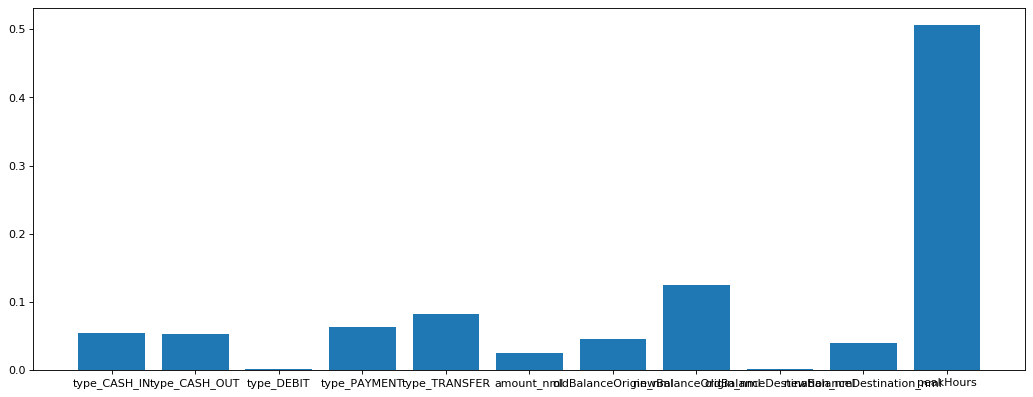

CPU times: user 790 ms, sys: 28 ms, total: 818 ms
Wall time: 487 ms


In [25]:
%%time
if also_local_training:
     fields_short_names = [s.replace('balance', 'Bal') for s in df.columns[1:]]
     figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
     pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_, tick_label=fields_short_names)
        
     pyplot.show()

## Print same metrics as with Sagemaker; also plot the precision-recall curve (good for unbalanced datasets)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
f1: 0.8075
balanced accuracy: 0.9993
accuracy: 0.9994
precision: 0.6775
recall: 0.9992
zero one loss: 0.0006


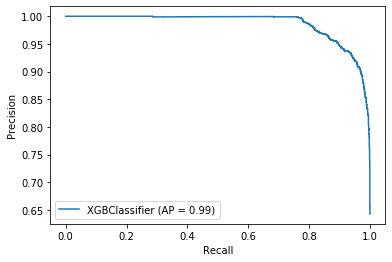

In [26]:
%time
if also_local_training:
    y_pred = model.predict(X_test)
    calculate_metrics(y_test,y_pred) 
    plot_precision_recall_curve(model, X_test, y_test)  